In [234]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

### **Data Exploration**

In [235]:
# Load the dataset
customer_df = pd.read_csv('customers.csv')
customer_df.info()
customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         2066 non-null   int64  
 1   CHURNRISK                  2066 non-null   object 
 2   GENDER                     2063 non-null   object 
 3   STATUS                     2066 non-null   object 
 4   CHILDREN                   2066 non-null   int64  
 5   ESTINCOME                  2066 non-null   float64
 6   HOMEOWNER                  2066 non-null   object 
 7   AGE                        2066 non-null   int64  
 8   TOTALDOLLARVALUETRADED     2066 non-null   float64
 9   TOTALUNITSTRADED           2066 non-null   int64  
 10  LARGESTSINGLETRANSACTION   2066 non-null   float64
 11  SMALLESTSINGLETRANSACTION  2066 non-null   float64
 12  PERCENTCHANGECALCULATION   2066 non-null   float64
 13  DAYSSINCELASTLOGIN         2066 non-null   int64

,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,1703,Medium,NaN,M,2,28766.9,N,47,6110.61,58,1527.6525,152.76525,8.70,2,13,0.0000,152.76525
1,1704,Low,NaN,M,2,91272.2,Y,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,1705,Low,NaN,S,0,73228.3,N,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,1706,High,M,M,1,64792.3,N,52,13051.31,36,6525.6550,652.56550,9.00,3,6,0.0000,652.56550
4,1707,High,F,S,0,93322.1,Y,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,0.0000,1496.14950


In [236]:
# Count the duplicates
customer_df.duplicated().sum()

0

In [237]:
# Get the columns with missing values
missing_columns = customer_df.columns[customer_df.isnull().any()]
# Count the missing values
customer_df[missing_columns].isnull().sum()

GENDER    3
dtype: int64

In [238]:
# Count the samples with value '0' in the 'NETREALIZEDGAINS_YTD' column
netrg = customer_df['NETREALIZEDGAINS_YTD'].value_counts()
netrg_df = pd.DataFrame({'Value': netrg.index, 'Count': netrg.values})
netrg_df.head()

,Value,Count
0,0.0000,1349
1,1133.1135,9
2,1398.6400,9
3,1022.6025,9
4,543.5545,9


In [239]:
# Count the samples with value '0' in the 'NETREALIZEDLOSSES_YTD' column
netrl = customer_df['NETREALIZEDLOSSES_YTD'].value_counts()
netrl_df = pd.DataFrame({'Value': netrl.index, 'Count': netrl.values})
netrl_df.head()

,Value,Count
0,0.000,780
1,100.010,13
2,518.052,11
3,50.005,10
4,1259.126,10


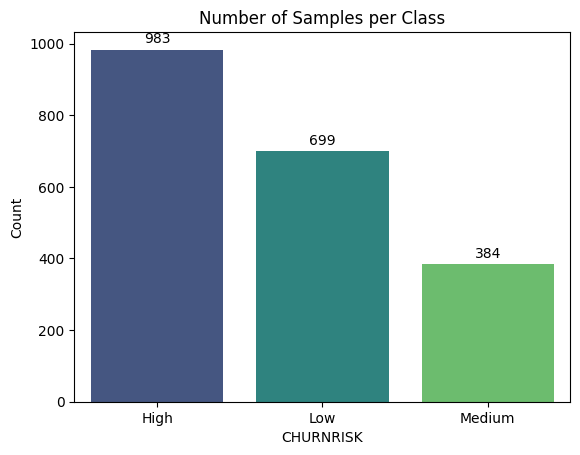

In [240]:
# Visualize the number of samples per class
churnrisk_distribution = customer_df['CHURNRISK'].value_counts()
sns.barplot(x=churnrisk_distribution.index, 
            y=churnrisk_distribution.values, 
            hue=churnrisk_distribution.index, 
            palette='viridis')

# Label the bars with their values
for i, value in enumerate(churnrisk_distribution.values):
    plt.text(i, value + 10, str(value), ha='center', va='bottom')

plt.title('Number of Samples per Class')
plt.xlabel('CHURNRISK')
plt.ylabel('Count')
plt.show()

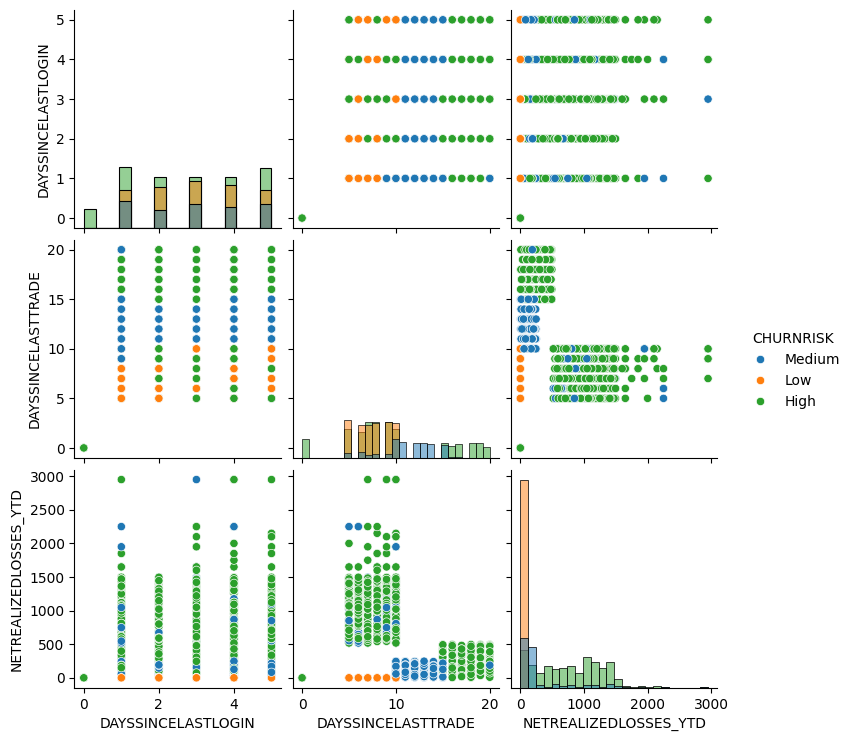

In [241]:
# Visualize the data distribution
sns.pairplot(customer_df,
    hue='CHURNRISK',
    palette=sns.color_palette(n_colors=3),
    vars=['DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDLOSSES_YTD'],
    diag_kind='hist')

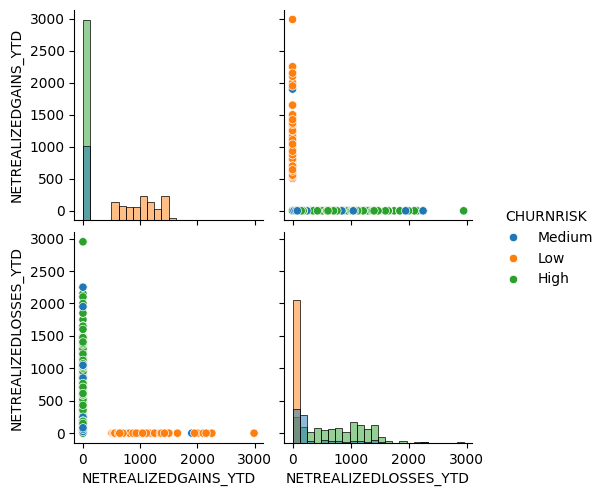

In [242]:
# Visualize the data distribution
sns.pairplot(customer_df,
    hue='CHURNRISK',
    palette=sns.color_palette(n_colors=3),
    vars=['NETREALIZEDGAINS_YTD', 'NETREALIZEDLOSSES_YTD'],
    diag_kind='hist')

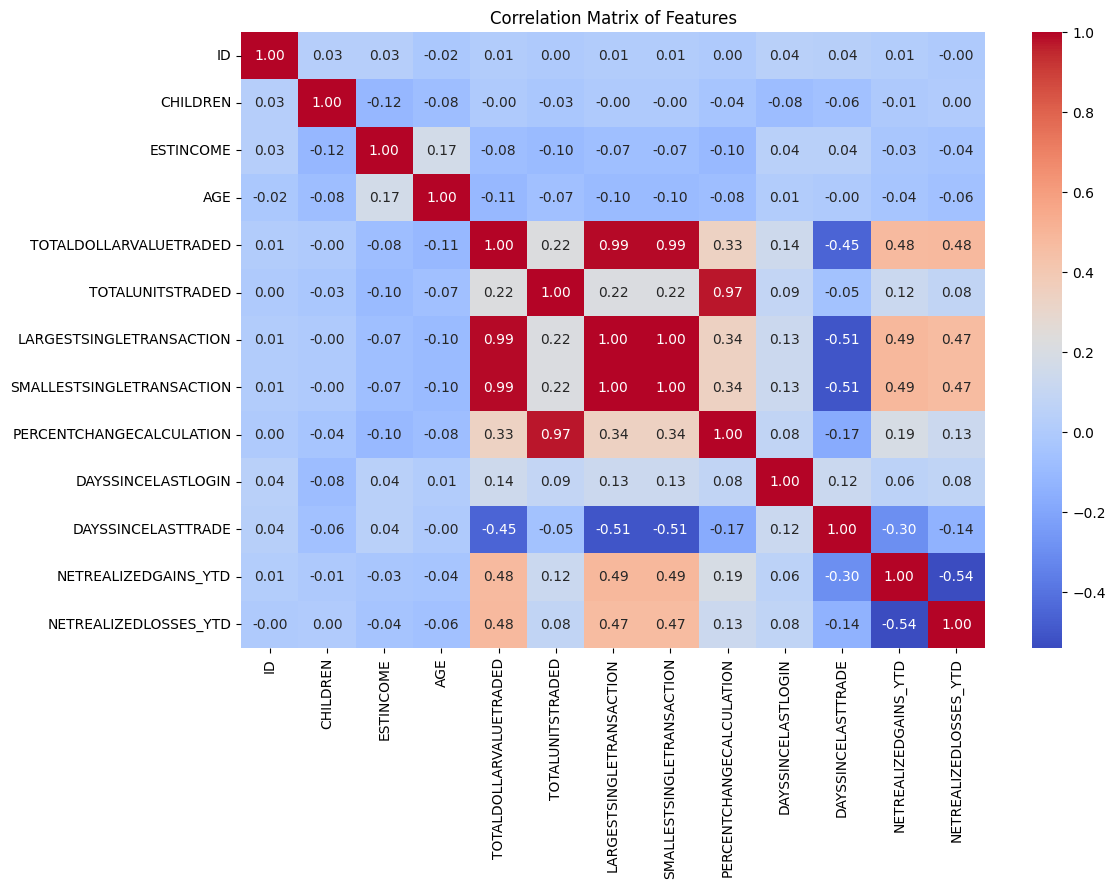

In [243]:
# Visualize the correlation of each features
correlation_matrix = customer_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

### **Data Preprocessing**

In [244]:
# Replace and 0 with null for imputing
customer_df['NETREALIZEDGAINS_YTD'] = customer_df['NETREALIZEDGAINS_YTD'].replace(0, np.nan)
customer_df[['GENDER', 'NETREALIZEDGAINS_YTD']].isna().sum()

GENDER                     3
NETREALIZEDGAINS_YTD    1349
dtype: int64

In [245]:
# Select categorical features except the target variable
categorical_columns = customer_df.select_dtypes(include=['object']).columns
# Get the index of the rows with missing values since label encoder will impute the missing values
missing_rows = customer_df.isna()

le = LabelEncoder()
# Transform the categorical columns into numerical columns
for column in categorical_columns:
    customer_df[column] = le.fit_transform(customer_df[column])

customer_df.head()

,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,1703,2,2,1,2,28766.9,0,47,6110.61,58,1527.6525,152.76525,8.70,2,13,NaN,152.76525
1,1704,1,2,1,2,91272.2,1,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,1705,1,2,2,0,73228.3,0,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,1706,0,1,1,1,64792.3,0,52,13051.31,36,6525.6550,652.56550,9.00,3,6,NaN,652.56550
4,1707,0,0,2,0,93322.1,1,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,NaN,1496.14950


In [246]:
# Replace rows with missing values with null
for column in missing_rows.columns:
    customer_df[column] = customer_df[column].where(~missing_rows[column], np.nan)

customer_df[['GENDER', 'NETREALIZEDGAINS_YTD']].isna().sum()

GENDER                     3
NETREALIZEDGAINS_YTD    1349
dtype: int64

In [247]:
# Fill missing values using prediction from model
def fill_missing_values(df, target_column):
    missing_rows = df[df[target_column].isna()]
    non_missing_rows = df[~df[target_column].isna()]
    
    model = RandomForestRegressor(random_state=42)
    X = non_missing_rows.drop(columns=[target_column])
    y = non_missing_rows[target_column]
    model.fit(X, y)

    X_missing = missing_rows.drop(columns=[target_column])
    predicted_values = model.predict(X_missing)
    
    # Fill missing values with predictions
    df.loc[df[target_column].isna(), target_column] = predicted_values

    accuracy = model.score(X, y)
    print(f'{target_column} Accuracy: {accuracy:.4f}')

# List the columns to impute
columns_with_nan = ['GENDER', 'NETREALIZEDGAINS_YTD']

for column in columns_with_nan:
    fill_missing_values(customer_df, column)

customer_df[columns_with_nan].isna().sum()

GENDER Accuracy: 0.9846
NETREALIZEDGAINS_YTD Accuracy: 0.9989


GENDER                  0
NETREALIZEDGAINS_YTD    0
dtype: int64

In [248]:
# Standardize the numerical features except the target variable since it is binary
columns = customer_df.drop(columns='CHURNRISK').columns

std_scaler = StandardScaler()
customer_df[columns] = std_scaler.fit_transform(customer_df[columns])
customer_df.head()

,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,1.124240,2,1.220834,-0.746612,1.012959,-0.738588,-0.737628,0.281434,-1.011294,-0.010312,-1.168367,-1.168367,-0.332917,-0.602899,0.857719,-0.990789,-0.510607
1,1.125917,1,1.283229,-0.746612,1.012959,1.290924,1.355696,-1.193460,1.094057,-0.790986,1.084439,1.084439,-0.723373,0.732138,0.151724,1.181219,-0.795935
2,1.127594,1,-0.651007,1.205920,-1.359800,0.705049,-0.737628,-0.053769,0.638301,-0.530761,0.659009,0.659009,-0.454710,0.732138,-1.024934,0.591475,-0.795935
3,1.129270,0,1.324825,-0.746612,-0.173420,0.431137,-0.737628,0.616638,-0.311526,-0.391974,-0.227619,-0.227619,-0.311424,0.064619,-0.789603,-0.637111,0.422898
4,1.130947,0,-0.754998,1.205920,-1.359800,1.357483,1.355696,-0.187850,1.389491,-0.877727,1.360216,1.360216,-0.812928,0.732138,-0.083608,1.563626,1.998506


In [249]:
# Drop unnecessary column
customer_df.drop(columns=['ID', 'GENDER', 'STATUS', 'SMALLESTSINGLETRANSACTION', 'HOMEOWNER', 
                          'TOTALDOLLARVALUETRADED', 'TOTALUNITSTRADED', 'CHILDREN'], inplace=True)
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CHURNRISK                 2066 non-null   int32  
 1   ESTINCOME                 2066 non-null   float64
 2   AGE                       2066 non-null   float64
 3   LARGESTSINGLETRANSACTION  2066 non-null   float64
 4   PERCENTCHANGECALCULATION  2066 non-null   float64
 5   DAYSSINCELASTLOGIN        2066 non-null   float64
 6   DAYSSINCELASTTRADE        2066 non-null   float64
 7   NETREALIZEDGAINS_YTD      2066 non-null   float64
 8   NETREALIZEDLOSSES_YTD     2066 non-null   float64
dtypes: float64(8), int32(1)
memory usage: 137.3 KB


### **Model Training**

In [250]:
# Split the dataset into features and target variable
X = customer_df.drop(columns=['CHURNRISK'])
y = customer_df['CHURNRISK']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training: {X_train.shape[0]}')
print(f'Testing: {X_test.shape[0]}')

Training: 1652
Testing: 414


In [251]:
# Peform hyperparameter tuning using GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 10]
}

model = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

c:\Users\Jhondale\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 15, 20],
                         'min_samples_leaf': [1, 4, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

### **Model Evaluation**

In [252]:
# Display the best score and parameters
best_score = grid_search.best_score_
print(f'Best Score: {best_score:.4f}')
grid_search.best_params_

Best Score: 0.9437


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

In [253]:
# Calculate the accuracy from the best classifier model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9541


In [254]:
# Display the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       208
           1       0.98      1.00      0.99       133
           2       0.95      0.78      0.86        73

    accuracy                           0.95       414
   macro avg       0.96      0.92      0.94       414
weighted avg       0.95      0.95      0.95       414



### **Model Visualization**

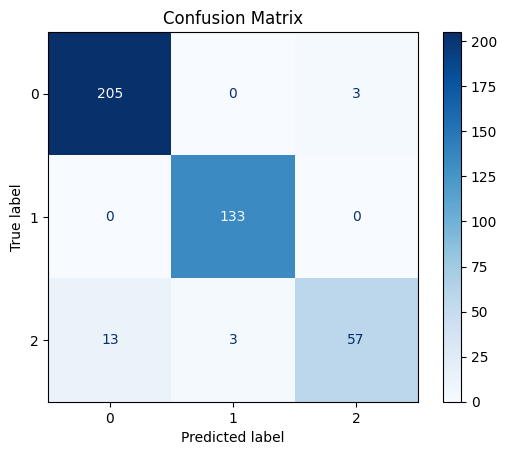

In [ ]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

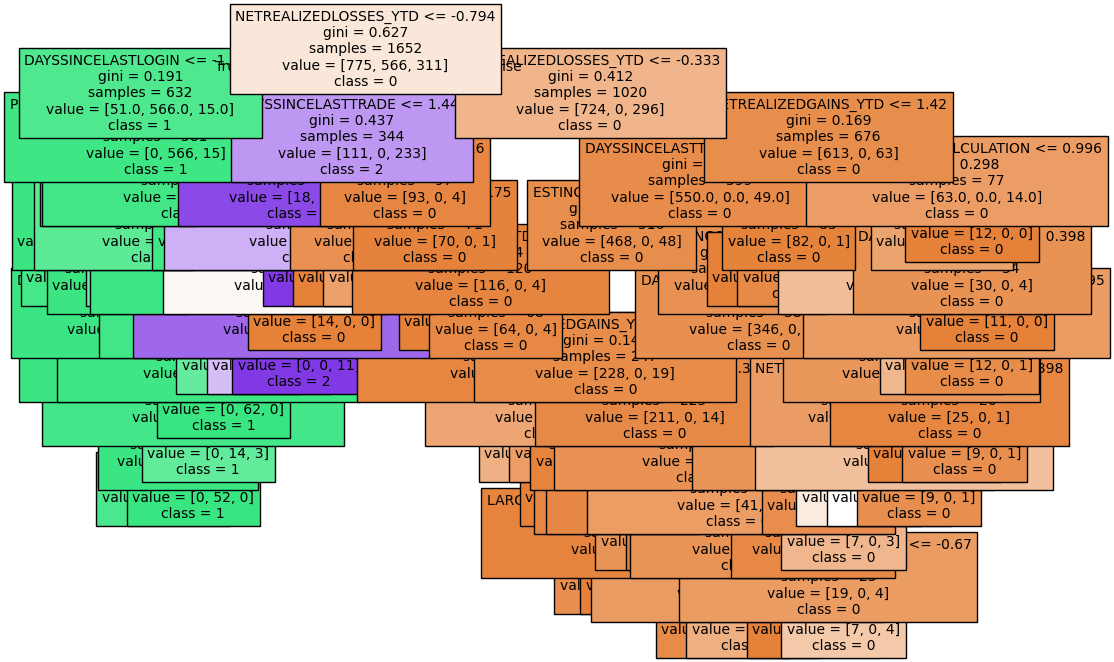

In [283]:
# Convert class names to strings
class_names = [str(cls) for cls in best_model.classes_]

# Visualize the tree structure
plt.figure(figsize=(12, 8))
plot_tree(best_model,
          feature_names=X.columns,
          class_names=class_names,
          filled=True,
          fontsize=10)
plt.show()

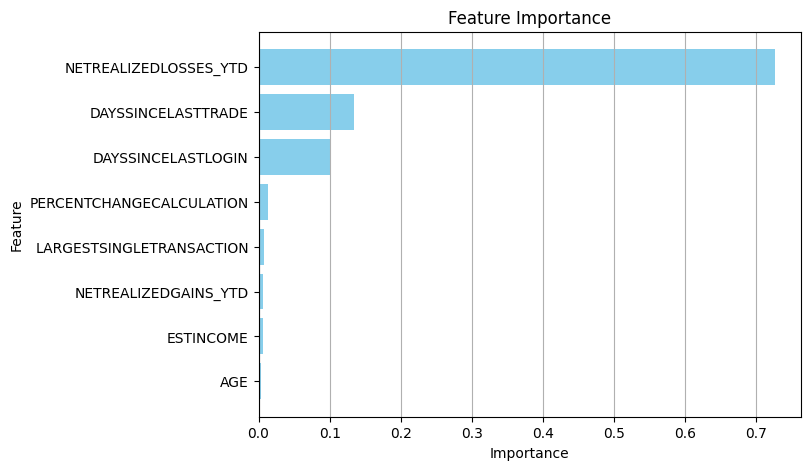

In [278]:
# Extract feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance')

# Visualize feature importances
plt.figure(figsize=(7, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.grid(axis='x', linestyle='-')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()